# TSIA202a - Third Practice Session

The goal of this third partical work is to use an AR(p) process to model a speech signal, and show that this approch is surprisingly powerful despite its simplicity.

The proposed synthesis algorithm divides into several steps.
1. Filter the audio signal to emphasize the highest frequencies (in order to flatten the spectrum and reduce precision issues with FFT computations).
2. Split the signal into several overlapping frames and iterate over them.
    1. Detect if the frame corresponds to noise or to a voiced signal, and estimate the fundamental frequency in the later case.
    2. Estimate the AR(p) coefficients using Yule-Walker equations.
    3. Re-synthetise the frame using the AR(p) coefficients, starting from a white noise in the case of a noisy frame, or a Dirac comb in the case of a voiced frame.
3. Overlap-add the synthesized frames with a Hanning window.
4. Filter the synthesised signal to de-emphasize the highest frequencies.

We propose to implement this algorithm in two parts. First, we will derive the Yule-Walker equations, and test them on synthetic data. Then, we will code the synthesis algorithm and apply it on a real world speech signal.


# 1. Yule-Walker equations

Let us consider a causal, zero-mean, AR(p) process defined by the following recurrent equation: 
$$
X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \ldots + \phi_p X_{t-p} + Z_t
$$
where $\{Z_t , t \in \mathbb{Z}\}$ is a weak white noise with variance $\sigma^2$.

1. Show that, $\forall h \geq 1, \mathbb{E}[X_{t-h}Z_t]=0$.
2. Deduce a recurrent relation between $\gamma(h)$ and $\gamma(h-1),\gamma(h-2),\ldots,\gamma(h-p)$, for $h \geq 1$.
3. We consider separately the case $h=0$: find a new relationship between $\gamma(0)$ and $\gamma(-1),\gamma(-2),\ldots,\gamma(-p)$.
4. Put these relationships in matrix form:
\begin{equation}
\Gamma_{p+1}[1 \; -\phi_1 \; \ldots \; -\phi_p]^T = [\sigma^2 \; 0 \; \ldots \; 0]^T 
\end{equation}
where $\Gamma_{p+1}$ is a suitable Toeplitz matrix that you have to determine.

# 2. Evaluation on synthetic data

We will now evaluate equation $(1)$ on a synthetically generated AR(p) process.

1. Generate n=1000 samples of an AR(4) process.
2. Estimate $\Gamma_{p+1}$ using these samples.
3. Use equation $(1)$ to estimate $\sigma^2$ and the coefficients $\phi_1,\phi_2,\ldots,\phi_p$. Compute the relative error between the estimated and the true coefficients.
4. Estimate power spectral distribution of the synthesized signal. Compare with the theoretical distribution obtained from the poles of $1/\Phi(z^{-1})$.

# 3. Speech modeling

We will now implement the synthesis algorithm and evaluate it on a speech signal. 

A code template is provided below. We will use the file audio.wav to test the algorithm. 


LIsten to the original and synthesized signal by using any audio player. Try to modify the pitch of the synthesised signal and listen to the result.


In [1]:
## imports
import librosa 
import soundfile as sf
import scipy
import numpy as np
import math
from collections import defaultdict
from tqdm import tqdm
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML

---
# <center> Partie 1: Équations de Yule-Walker </center>
---

### $\textbf{\textcolor{Goldenrod}{Question 1:}}$

$$
X_t = \sum_{k=1}^p \phi_k X_{t-k} + Z_t
$$
Avec $Z_t \sim \text{WN}(0, \sigma^2)$.

Soit $ h \geq 1 $,
$$
X_{t-h} = \sum_{k=1}^p \phi_k X_{t-h-k} + Z_{t-h}.
$$

Donc:
$$
\mathbb{E}[X_{t-h}Z_t] = \sum_{k=1}^p \phi_k \mathbb{E}[X_{t-h-k}Z_t] + \mathbb{E}[Z_{t-h}Z_t].
$$
Or, 

- $ Z_t \perp Z_s $ pour $ s \neq t $, donc $ \mathbb{E}[Z_{t-h}Z_t] = 0 $ pour $ h \geq 1 $.
- Le processus est causal, donc $ X_{t-h-k} $ est une combinaison linéaire de $ \{Z_s, s \leq t-h-k\} $. Comme $ Z_t \perp Z_s $ pour $ s < t $, on a $ \mathbb{E}[X_{t-h-k}Z_t] = 0 $ pour tout $ k $.

Donc : 
$$
\mathbb{E}[X_{t-h}Z_t] = \sum_{k=1}^p \phi_k \cdot 0 + 0 = 0.
$$

Ainsi, 
$$
\textbf{\textcolor{Goldenrod}{\boxed{\forall h \geq 1, \quad\mathbb{E}[X_{t-h}Z_t] = 0}}}
$$




---
### $\textbf{\textcolor{Goldenrod}{Question 2:}}$

$ \gamma(h) = \gamma(-h) = Cov(X_t,X_{t-h}) = \mathbb{E}[X_t X_{t-h}]$ $\quad$ $($ Car  $\mathbb{E}[X_t] = 0$ et $\gamma$ stationnaire donc  symétrique  $)$

Et
$$
\mathbb{E}[X_t X_{t-h}] = \sum_{k=1}^p \phi_k \mathbb{E}[X_{t-k} X_{t-h}] + \mathbb{E}[Z_t X_{t-h}].
$$

Or d'après la question 1),$\quad  \forall h \geq 1,  \mathbb{E}[Z_t X_{t-h}] = 0 $.

Ainsi, 
$$
\textbf{\textcolor{Goldenrod}{\boxed{\forall h \geq 1,\quad \gamma(h) = \sum_{k=1}^p \phi_k \gamma(h-k)}}}
$$






---
### $\textbf{\textcolor{Goldenrod}{Question 3:}}$

$\gamma(0) = \mathbb{E}[X_t^2] $ $($ Car  $\mathbb{E}[X_t] = 0)$

Et 
$$
\mathbb{E}[X_t^2] = \sum_{k=1}^p \phi_k \mathbb{E}[X_t X_{t-k}] + \mathbb{E}[X_t Z_t].
$$
Or,
$$
\mathbb{E}(X_t Z_t) = \mathbb{E} \left[ \left( \sum_{k=1}^p \phi_k X_{t-k} + Z_t \right) Z_t \right]
$$


$$
\hspace{1.7cm}= \sum_{k=1}^p \phi_k \underbrace{\mathbb{E}(X_{t-k} Z_t)}_{= 0 \, \text{d'après (1)}} + \underbrace{\mathbb{E}(Z_t^2)}_{= \text{Var}(Z_t) = \sigma^2}
$$

$$
\hspace{-2.35cm}= \sigma^2
$$
Et $ \mathbb{E}[X_t X_{t-k}] = \gamma(k) = \gamma(-k)$ pour tous $k \geq 1 $

Donc: 
$$
\mathbb{E}[X_t^2] = \sum_{k=1}^p \phi_k  \gamma(-k) +\sigma^2
$$

Ainsi, 
$$
\textbf{\textcolor{Goldenrod}{\boxed{ \gamma(0) = \sum_{k=1}^p \phi_k \gamma(-k) + \sigma^2} }}
$$

---
### $\textbf{\textcolor{Goldenrod}{Question 4:}}$

$$
\gamma(h) = 
\begin{cases}
\sum_{k=1}^p \phi_k \gamma(-k) + \sigma^2, \quad \text{si } h = 0  \\ 
\ \hspace{8cm} (1) \\
\sum_{k=1}^p \phi_k \gamma(h-k), \quad \text{si } h \geq 1 
\end{cases}
$$ 

On pose : 
$\boldsymbol{\gamma}_i = [ \gamma(i) \; \gamma(i-1) \; \ldots \; \gamma(i-p)] $ et $\boldsymbol{\phi} = [1 \; -\phi_1 \; \ldots \; -\phi_p]^T$

On a : 
$$
\langle \mathbf{\boldsymbol{\gamma}_i}, \mathbf{\boldsymbol{\phi}} \rangle = \gamma(i) - \sum_{k=1}^p \phi_k \gamma(i-k) 
$$


- Pour $ i = 0 $, 
$$
\boldsymbol{\gamma}_0 \cdot \boldsymbol{\phi} = \gamma(0) - \sum_{k=1}^p \phi_k \gamma(k) = \sigma^2 \quad \quad D'après \quad (1)
$$


- Pour $ i \geq 1 $, on a:
$$
\boldsymbol{\gamma}_i \cdot \boldsymbol{\phi} = \gamma(i) - \sum_{k=1}^p \phi_k \gamma(i-k) = 0 \quad \quad D'après \quad (1) \quad aussi
$$


Donc en empilant les vecteurs $ \boldsymbol{\gamma}_i $ pour $ i = 0, 1, \ldots, p $, on construit alors la matrice Toeplitz $ \Gamma_{p+1} $ :
$$
\Gamma_{p+1} =
\begin{bmatrix}
\gamma(0) & \gamma(1) & \gamma(2) & \ldots & \gamma(p) \\
\gamma(1) & \gamma(0) & \gamma(1) & \ldots & \gamma(p-1) \\
\gamma(2) & \gamma(1) & \gamma(0) & \ldots & \gamma(p-2) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\gamma(p) & \gamma(p-1) & \gamma(p-2) & \ldots & \gamma(0)
\end{bmatrix}
$$

$(\Gamma_{p+1})_{s,t} = \gamma(|s - t|),$ où $ s, t = 0, 1, \ldots, p $.

Ainsi: 
$$
\textbf{\textcolor{Goldenrod}{\boxed{\Gamma_{p+1} \cdot \boldsymbol{\phi} = [\sigma^2 \; 0 \; \ldots \; 0]^T}}}
$$





---
# <center> Partie 2 : Évaluation sur des données synthétiques </center>
---

### $\textbf{\textcolor{Goldenrod}{Question 1:}}$

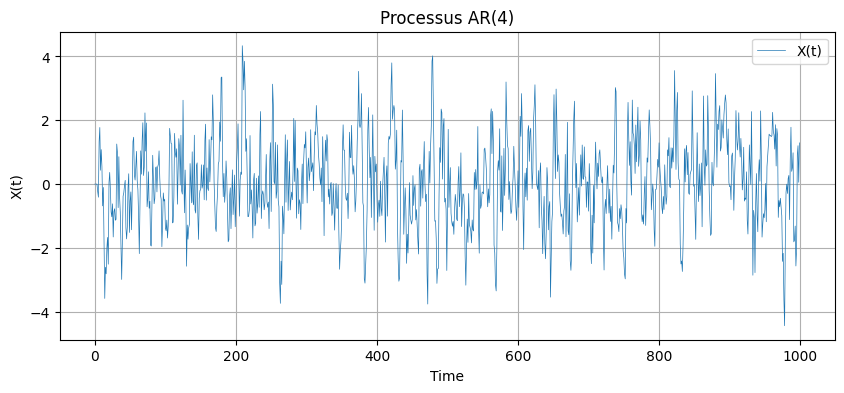

In [2]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000  
phi = [0.75, -0.25, 0.4, -0.3]  # Coefficients AR
sigma2 = 1  
np.random.seed(42)  # Pour des résultats reproductibles

Z = np.random.normal(0, np.sqrt(sigma2), n)

X = np.zeros(n)

for t in range(4, n):
    X[t] = sum(phi[i] * X[t - i - 1] for i in range(4)) + Z[t] # processus AR(4)

plt.figure(figsize=(10, 4))
plt.plot(X, label="X(t)", linewidth=0.5)
plt.title("Processus AR(4)")
plt.xlabel("Time")
plt.ylabel("X(t)")
plt.legend()
plt.grid()
plt.show()


---
### $\textbf{\textcolor{Goldenrod}{Question 2:}}$

In [3]:

def estimate_autocovariance(X, p): # Estimation empirique de l'autocovariance
    n = len(X)
    gamma = np.zeros(p + 1)
    for h in range(p + 1):
        gamma[h] = np.sum(X[h:] * X[:n-h]) / n
    return gamma


def toeplitz_matrix(gamma, p):
    return np.array([[gamma[abs(i - j)] for j in range(p + 1)] for i in range(p + 1)])

p = 4  
gamma_estimated = estimate_autocovariance(X, p)
Gamma_p1 = toeplitz_matrix(gamma_estimated, p)


print("-------------------------------------------------")
print("Autocovariances estimées :",np.round(gamma_estimated, 2).tolist())
print("-------------------------------------------------")
print("Matrice Γ_{p+1} estimée :")
print("-------------------------------------------------")
for row in Gamma_p1:
    print(" | ".join(f"{val:.2f}" for val in row))



-------------------------------------------------
Autocovariances estimées : [1.83, 1.15, 0.67, 0.58, 0.14]
-------------------------------------------------
Matrice Γ_{p+1} estimée :
-------------------------------------------------
1.83 | 1.15 | 0.67 | 0.58 | 0.14
1.15 | 1.83 | 1.15 | 0.67 | 0.58
0.67 | 1.15 | 1.83 | 1.15 | 0.67
0.58 | 0.67 | 1.15 | 1.83 | 1.15
0.14 | 0.58 | 0.67 | 1.15 | 1.83


---
### $\textbf{\textcolor{Goldenrod}{Question 3:}}$

On sait que $\Gamma_{p+1}$ est inversible, on peut donc écrire : 
$$
\boldsymbol{\phi} = \Gamma_p^{-1} \boldsymbol{\gamma},
$$
où :
- $\Gamma_p$ est une sous-matrice de $\Gamma_{p+1}$ de taille $p \times p$, contenant les autocovariances $\gamma(h)$,
- $\boldsymbol{\gamma} = (\gamma(1), \gamma(2), \ldots, \gamma(p))^T$ est le vecteur des autocovariances.

Et 
$$
\sigma^2 = \gamma(0) - \sum_{k=1}^p \phi_k \gamma(k) \\
= \gamma(0) - \langle \boldsymbol{\phi}, \boldsymbol{\gamma} \rangle
$$


Pour le calcul de l'erreur relative, on utilise : 

$$
\text{Erreur relative} = \frac{\| \boldsymbol{\phi} - \boldsymbol{\phi}_{\text{true}} \|}{\| \boldsymbol{\phi}_{\text{true}} \|}
$$





In [4]:
def estimate_yule_walker(gamma, p): 
    Gamma_p = toeplitz_matrix(gamma, p)[1:, 1:] # Sans la première ligne et la première colonne
    Gamma_p += np.eye(len(Gamma_p)) * 1e-6
    gamma_vec = gamma[1:p+1]
    phi_estimated = np.linalg.solve(Gamma_p, gamma_vec)
    sigma2_estimated = gamma[0] - np.dot(phi_estimated, gamma_vec)
    return phi_estimated, sigma2_estimated


def relative_error(estimated_v, true_v):   
    norm_diff = np.linalg.norm(estimated_v - true_v)
    phi_norm = np.linalg.norm(true_v)
    return norm_diff / phi_norm

true_phi = np.array(phi)  
p = len(true_phi)  

phi_estimated, sigma2_estimated = estimate_yule_walker(gamma_estimated, p)

phi_error = relative_error(phi_estimated, true_phi)
sigma2_error = relative_error(sigma2_estimated, sigma2)

print("-------------------------------------------------")
print("Coefficients φ estimés :", np.round(phi_estimated, 2).tolist())
print("Variance σ^2 estimée :", np.round(sigma2_estimated, 2))
print("-------------------------------------------------")
print(f"Erreur relative sur les coefficients : {phi_error * 100:.2f}%")
print(f"Erreur relative sur σ^2 : {sigma2_error * 100:.2f}%")



-------------------------------------------------
Coefficients φ estimés : [0.73, -0.22, 0.4, -0.32]
Variance σ^2 estimée : 0.96
-------------------------------------------------
Erreur relative sur les coefficients : 4.44%
Erreur relative sur σ^2 : 4.42%


---
### $\textbf{\textcolor{Goldenrod}{Question 4:}}$

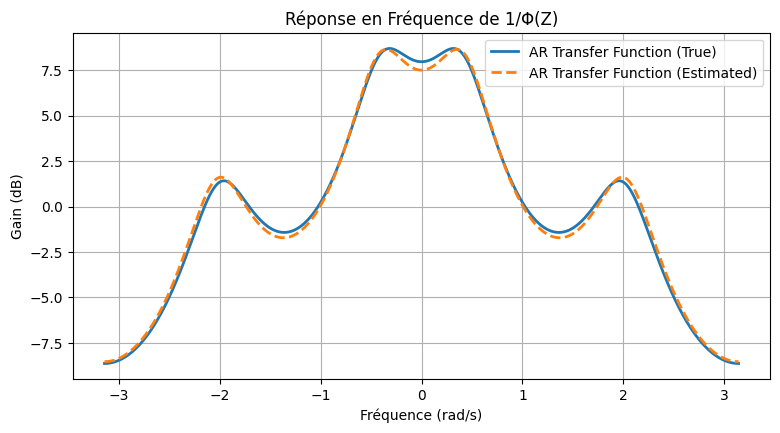

In [5]:
from scipy.signal import welch, freqz

# Fonction pour calculer la PSD théorique
def theoretical_psd(frequencies, phi, sigma2):
    psd = []
    for f in frequencies:
        denominator = np.abs(1 - np.sum([phi[k] * np.exp(-2j * np.pi * f * (k + 1)) for k in range(len(phi))]))**2
        psd.append(sigma2 / denominator)
    return np.array(psd)

frequencies = np.linspace(0, 0.5, 500)  # Fréquences normalisées 
psd_theoretical = theoretical_psd(frequencies, phi_estimated, sigma2_estimated)

# PSD empirique 
frequencies_empirical, psd_empirical = welch(X, nperseg=256, scaling='density')

coeffs_true = np.concatenate(([1], -true_phi))  
coeffs_estimated = np.concatenate(([1], -phi_estimated))  
omega = np.linspace(-np.pi, np.pi, len(frequencies) * 2)  # Fréquences sur [-π, π]

_, response_true = freqz(1, coeffs_true, worN=omega)  
_, response_estimated = freqz(1, coeffs_estimated, worN=omega)  

plt.figure(figsize=(9, 4.5))
plt.plot(omega, 20 * np.log10(np.abs(response_true)), label="AR Transfer Function (True)", linewidth=2)
plt.plot(omega, 20 * np.log10(np.abs(response_estimated)), label="AR Transfer Function (Estimated)", linestyle='--', linewidth=2)
plt.title("Réponse en Fréquence de 1/Φ(Z)")
plt.xlabel("Fréquence (rad/s)")
plt.ylabel("Gain (dB)")
plt.legend()
plt.grid()
plt.show()




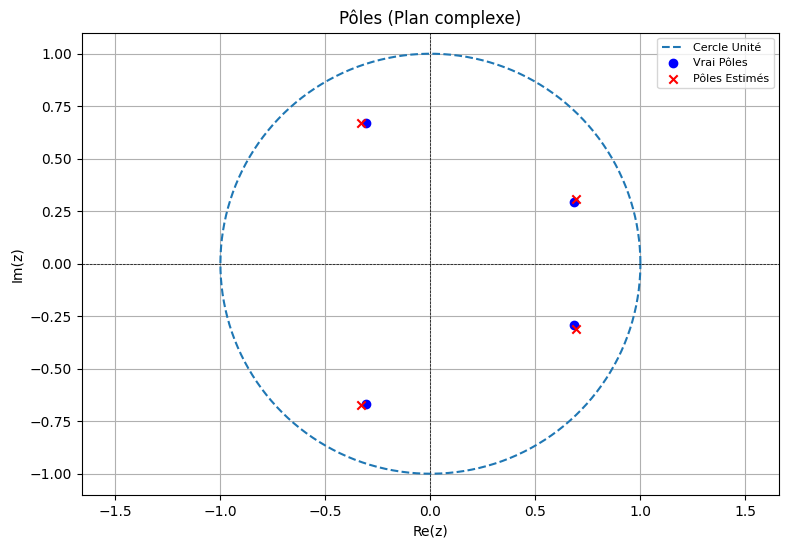

In [ ]:
poles_true = np.roots(coeffs_true)  
poles_estimated = np.roots(coeffs_estimated)  

theta = np.linspace(0, 2 * np.pi, 500)
circle = np.exp(1j * theta)  

plt.figure(figsize=(9, 6))
plt.plot(circle.real, circle.imag, linestyle='--', label="Cercle Unité")  
plt.scatter(poles_true.real, poles_true.imag, color="blue", label="Vrai Pôles ", zorder=5)  
plt.scatter(poles_estimated.real, poles_estimated.imag, color="red", marker="x", label="Pôles Estimés", zorder=5)  
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.title("Pôles (Plan complexe)")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.legend(loc="upper right", fontsize=8)
plt.axis('equal') 
plt.grid()
plt.show()

---
# <center> Partie 3 : Modélisation de la parole </center>
---

In [212]:
# Test avec un signal AR synthétique
phi_true = [0.75, -0.25, 0.4, -0.3]
sigma2_true = 1.0
n = 1000
Z = np.random.normal(0, np.sqrt(sigma2_true), n)
X_test = np.zeros(n)
for t in range(len(phi_true), n):
    X_test[t] = sum(phi_true[i] * X_test[t - i - 1] for i in range(len(phi_true))) + Z[t]

# Estimation
gamma_test = estimate_autocovariance(X_test, len(phi_true))
phi_estimated, sigma2_estimated = estimate_yule_walker(gamma_test, len(phi_true))

# Résultats
print(f"Coefficients AR réels : {phi_true}")
print(f"Coefficients AR estimés : {phi_estimated}")
print(f"Variance σ^2 réelle : {sigma2_true}")
print(f"Variance σ^2 estimée : {sigma2_estimated}")

# Analyse des erreurs
phi_error = relative_error(phi_estimated, phi_true)
sigma_error = relative_error(sigma2_estimated, sigma2_true)
print(f"Erreur relative sur les coefficients AR : {phi_error * 100:.2f}%")
print(f"Erreur relative sur la variance σ^2 : {sigma_error * 100:.2f}%")


Coefficients AR réels : [0.75, -0.25, 0.4, -0.3]
Coefficients AR estimés : [ 0.72020499 -0.23227306  0.38949447 -0.28071846]
Variance σ^2 réelle : 1.0
Variance σ^2 estimée : 0.9927277859604382
Erreur relative sur les coefficients AR : 4.39%
Erreur relative sur la variance σ^2 : 0.73%


In [10]:
## hyperparameters

sampling_rate = 8000 # (Hz)
frame_duration = 0.04 # duration of the analysis frames (seconds)
overlap_ratio = 0.5 # overlap ratio between two consecutive analysis frames
p = 30 # AR(p) model order
f_min = 80 # minimum frequency for pitch detection (Hz)
f_max = 400 # maximum frequency for pitch detection Hz)
pitch_detection_threshold = 0.5 # threshold for pitch detection

In [11]:
## synthesis

# load audio
x = librosa.load('audio.wav', sr=sampling_rate)[0]

# pre-emphasis filtering
x = scipy.signal.lfilter([1, -0.98], [1], x)

# handy variables
n_frame = math.floor(len(x) / (sampling_rate * frame_duration * (1 - overlap_ratio))) - 1 # discard last frame
frame_length = int(sampling_rate * frame_duration)
min_period = math.floor(sampling_rate / f_max)
max_period = math.ceil(sampling_rate / f_min)
synthesis = np.zeros(len(x))
log_dict = defaultdict(list)

# loop over frames
for frame_index in tqdm(range(n_frame)):

    # extract frame
    start = int(frame_index * sampling_rate * frame_duration * (1 - overlap_ratio))
    end = start + frame_length
    frame = x[start:end]

    # detect pitch
    auto_covariance = np.fft.irfft(np.abs(np.fft.rfft(frame - np.mean(frame), (2*frame_length-1)))**2 / frame_length)[:frame_length]
    pitch, max_value = auto_covariance[min_period:].argmax() + min_period, auto_covariance[min_period:].max() / auto_covariance[0]
    if (pitch > max_period) or (max_value * frame_length / (frame_length - pitch) < pitch_detection_threshold): # detect silent frame 
        pitch = 0
    
    # estimate AR(p) coefficients
    gamma = estimate_autocovariance(frame - np.mean(frame), p)
    v = np.array([1 if k==0 else 0 for k in range(p+1)])
    coefficient, sigma = estimate_yule_walker(gamma, p)
    coefficient = np.concatenate(([1], -coefficient))

    # re-synthetise frame
    if pitch == 0:
        noise = np.random.normal(0, np.sqrt(sigma), frame_length + p)
        frame_r = scipy.signal.lfilter([1], coefficient, noise)
    else:
        dirac_comb = np.zeros(frame_length + p)
        dirac_comb[::pitch] = 1
        frame_r = scipy.signal.lfilter([1], coefficient, dirac_comb)
    frame_r = frame_r[p:]
    normalization_factor = np.sqrt(sigma / np.var(frame_r))
    frame_r = normalization_factor * frame_r[:frame_length]

    # overlap-add
    synthesis[start:end] += frame_r * np.hanning(frame_length)

    # compute power spectral density (for logging purposes)
    original_psd = np.abs(np.fft.rfft(frame))**2
    synthesis_psd = np.abs(np.fft.rfft(frame_r))**2

    # log
    log_dict["frame"].append(frame)
    log_dict["pitch"].append(pitch)
    log_dict["sigma"].append(sigma)
    log_dict["coefficient"].append(coefficient)
    log_dict["frame_r"].append(frame_r)
    log_dict["original_psd"].append(original_psd)
    log_dict["synthesis_psd"].append(synthesis_psd)

# de-emphasis filtering
synthesis = scipy.signal.lfilter([1], [1, -0.98], synthesis)

# log
sf.write('synthesis_p20.wav', synthesis, sampling_rate)
log_dict["synthesis"].append(synthesis)
log_dict = {k: np.array(v) for k, v in log_dict.items()}




100%|██████████| 279/279 [00:00<00:00, 1768.79it/s]


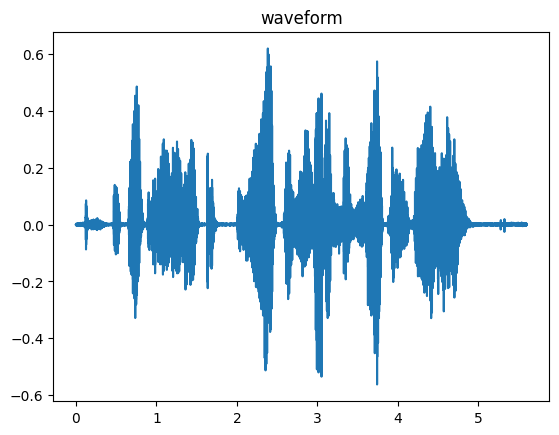

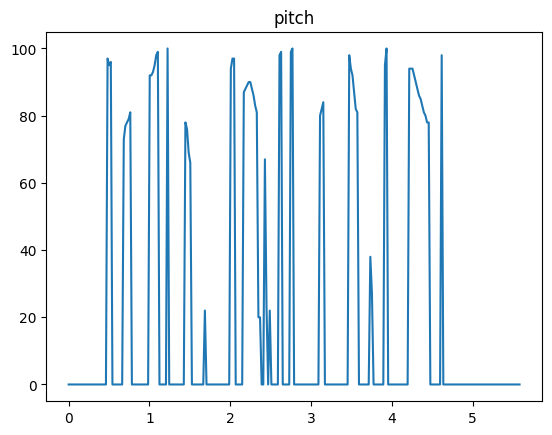

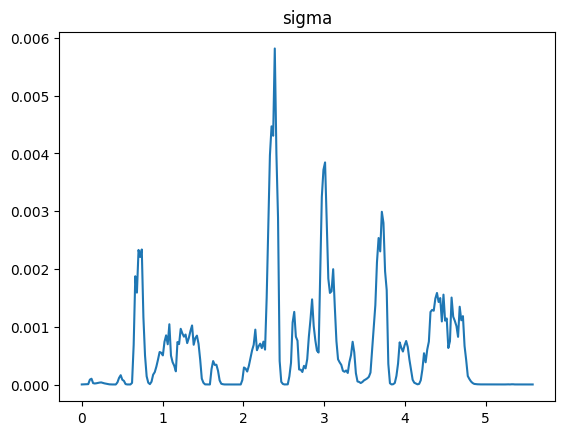

In [219]:
## plot

# time axis for plotting
sample_time = np.linspace(0, len(x)/sampling_rate, len(x))
frame_time = np.linspace(0, n_frame*frame_duration*(1-overlap_ratio), n_frame)

# waveform
plt.title("waveform")
plt.plot(sample_time, x)
plt.show()

# pitch
plt.title("pitch")
plt.plot(frame_time, log_dict["pitch"])
plt.show()

# variance
plt.title("sigma")
plt.plot(frame_time, log_dict["sigma"])
plt.show()

# power spectral density
fig, ax = plt.subplots()
fig.suptitle("estimated & theoretical spectral density")
y_min = min(log_dict["original_psd"].min(), log_dict["synthesis_psd"].min())
y_max = max(log_dict["original_psd"].max(), log_dict["synthesis_psd"].max())
def animate(i):
    ax.cla()
    ax.set_ylim([y_min-0.1, y_max+0.1])
    ax.plot(log_dict["original_psd"][i], label="original_psd")
    ax.plot(log_dict["synthesis_psd"][i], label="synthesis_psd")
animation = matplotlib.animation.FuncAnimation(fig, animate, frames=len(log_dict["original_psd"]))
display(HTML(animation.to_jshtml()))
plt.close()